# MATH50003 (2024–25)
# Lab 8: V.1 Fourier Expansions and V.2 Discrete Fourier Transform

This lab explores the practical implementation of Fourier expansions on a computer,
in particular, via use the periodic Trapezium rule for approximating the Fourier coefficients.
This has a number of wonderful properties including interpolating data exactly, and
can be expressed cleanly in terms of the Discrete Fourier Transform (DFT).
We also explore the closely related cousins of the Fourier expansion: the Fourier–Taylor expansion
(for functions with only non-negative Fourier coefficients) and the Cosine expansion (for even functions).

**Learning Outcomes**

Mathematical knowledge:

1. Computing Fourier coefficients and approximating Fourier expansions.
2. Extensions to Cosine expansions and discrete cosine coefficients.
3. The relationship between regularity and convergence of Fourier expansions.
4. The Discrete Fourier Transform and the Discrete Cosine Transform.
5. The interpolatory behaviour of approximate Fourier expansions.

Coding knowledge:

1. The QuadGK.jl package and `quadgk` function for black box numerical integration.
2. The FFTW.jl package and the `fft` function for applying the Discrete Fourier Transform fast.

We first load  packages we need including two new ones, FFTW.jl (for the fast Fourier transform)
and QuadGK.jl (for black-box numerical integration).

In [1]:
using LinearAlgebra, Plots, FFTW, QuadGK, Test

## V.1 Fourier Expansions

Consider the Fourier expansion
$$
f(x) = ∑_{k=-∞}^∞ f̂_k {\rm e}^{{\rm i}kθ}
$$
and the closely related Fourier–Taylor expansion
$$
f(x) = ∑_{k=0}^∞ f̂_k {\rm e}^{{\rm i}kθ}
$$
where
$$
f̂_k := {1 \over 2π} ∫_0^{2π} {\rm e}^{-{\rm i}kθ} f(x)  {\rm d}x.
$$
We will ultimately use the Trapezium rule to compute $f̂_k$ but for now we will use QuadGK.jl
to get a high-accuracy approximation. QuadGK.jl implements a black-box algorithm for computing
integrals via `quadgk`, eg.

In [2]:
σ,ε = quadgk(exp, 0, 1) # integrates exp(x) for x ∈ [0,1]

(1.7182818284590453, 2.220446049250313e-16)

This returns a 2-tuple, the first argument is an approximation to the integral

In [3]:
@test σ ≈ exp(1)-1

Test Passed

whilst the second argument is an estimate for the error, which in this case is spot-on:

In [4]:
abs(σ - (exp(1)-1))

2.220446049250313e-16

If we give an extra parameter `atol` we can specify the desired accuracy.
We can thus compute  approximations to the true Fourier coefficients that are accurate
to $10^{-12}$ via:

In [5]:
fouriercoefficient(f, k) = quadgk(θ -> f(θ)*exp(-im*k*θ), 0, 2π, atol=1E-12)[1]/(2π)
fouriercoefficient(exp, 0)

85.06698901813684 + 0.0im

We can use this to approximate a finite truncation of the Fourier series
$$
fₙ(θ) = ∑_{k=-m}^m f̂ₖ {\rm e}^{{\rm i}kθ}
$$
Here we implement this in code for the case of $f(θ) = \exp θ$:

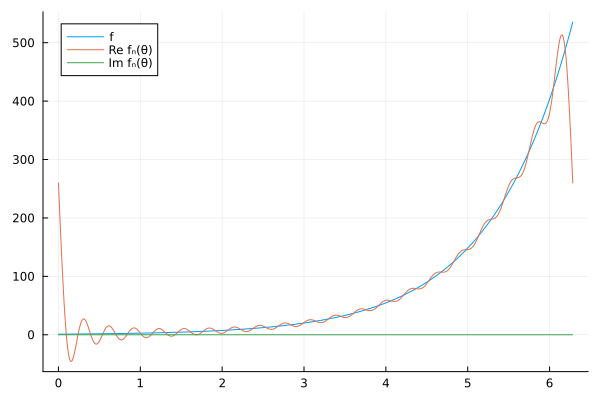

In [6]:
m = 20 # n = 2m+1 Fourier coefficients
f̂ = [fouriercoefficient(exp, k) for k = -m:m]
F = θ -> [exp(im*k*θ) for k = -m:m] # Create the Fourier basis
fₙ = θ -> transpose(F(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, exp.(g); label="f")
plot!(g, real(fₙ.(g)); label="Re fₙ(θ)")
plot!(g, imag(fₙ.(g)); label="Im fₙ(θ)")

Because of symmetry properties the imaginary part is numerically zero.
But observe also that the approximation overshoots at $0$ and $2π$, something
known as _Gibb's phenomenon_.

------

**Problem 1(a)** Repeat the above experiment for the non-symmetric truncation
$$
fₙ(θ) = ∑_{k=-m}^{m-1} f̂ₖ {\rm e}^{{\rm i}kθ}
$$
with $n = 2m$ Fourier coefficients, where $m = 20$,
for $f(θ) = \exp(θ)$, $f(θ) = \exp(\cos(θ))$, and $\exp(\exp({\rm i} θ))$. Is the imaginary part still
numerically zero?  Does the second example appear to converge at $0$ and $2π$?

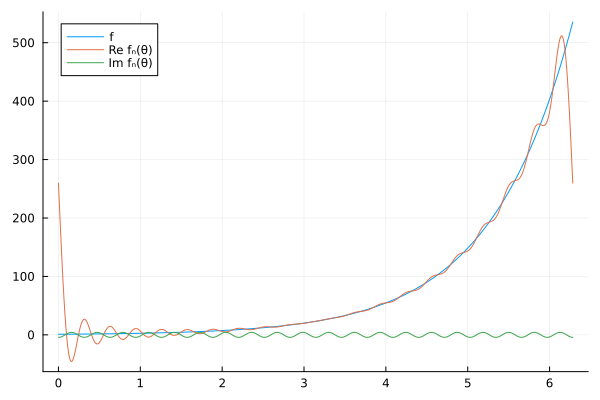

In [7]:
m = 20 # n = 2m Fourier coefficients
# TODO: plot the truncated Fourier expansion with coefficients ranging from -m:m-1
# SOLUTION
f̂ = [fouriercoefficient(exp, k) for k = -m:m-1]
F = θ -> [exp(im*k*θ) for k = -m:m-1] # Create the Fourier basis
fₙ = θ -> transpose(F(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, exp.(g); label="f")
plot!(g, real(fₙ.(g)); label="Re fₙ(θ)")
plot!(g, imag(fₙ.(g)); label="Im fₙ(θ)")
# The imaginary part is not zero

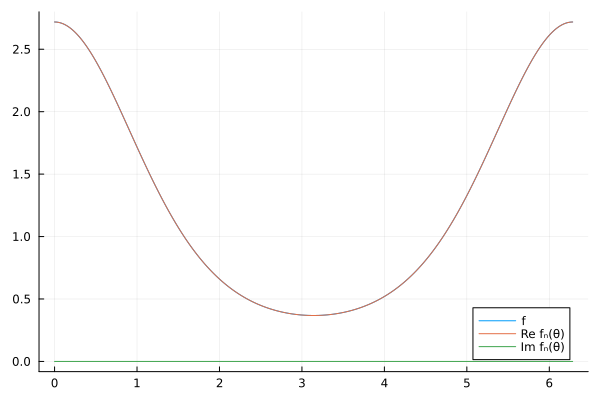

In [8]:
f = θ -> exp(cos(θ))
f̂ = [fouriercoefficient(f, k) for k = -m:m-1]
F = θ -> [exp(im*k*θ) for k = -m:m-1] # Create the Fourier basis
fₙ = θ -> transpose(F(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, f.(g); label="f")
plot!(g, real(fₙ.(g)); label="Re fₙ(θ)")
plot!(g, imag(fₙ.(g)); label="Im fₙ(θ)")
# The imaginary part is now numerically zero and the approximation is indistinguishable.

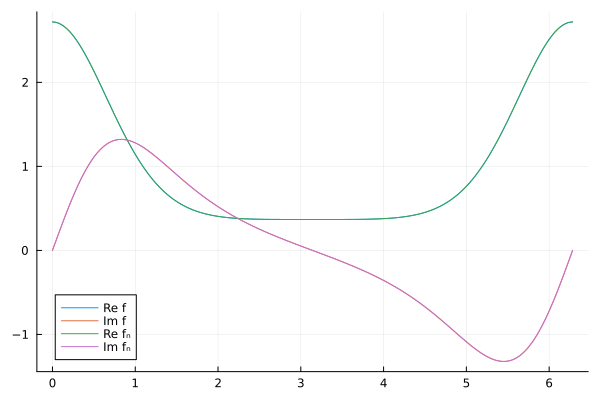

In [9]:
f = θ -> exp(exp(im*θ))
f̂ = [fouriercoefficient(f, k) for k = -m:m-1]
F = θ -> [exp(im*k*θ) for k = -m:m-1] # Create the Fourier basis
fₙ = θ -> transpose(F(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, real.(f.(g)); label="Re f")
plot!(g, imag.(f.(g)); label="Im f")
plot!(g, real(fₙ.(g)); label="Re fₙ")
plot!(g, imag(fₙ.(g)); label="Im fₙ")
# The real and imaginary parts match to high accuracy
# END

**Problem 1(b)**  Plot the finite Fourier-Taylor expansion
$$
fₙ(θ) = ∑_{k=0}^{ n-1} f̂ₖ {\rm e}^{{\rm i}kθ}
$$
where $n = 20$,
for $f(θ) = \exp(θ)$, $f(θ) = \exp(\cos(θ))$, and $\exp(\exp({\rm i} θ))$.
For which of these functions does the approximation appear to converge?

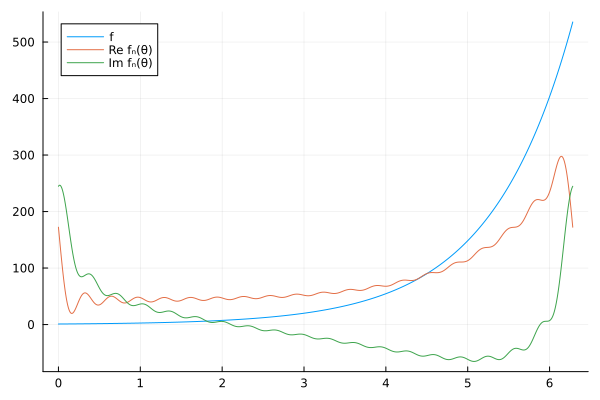

In [10]:
n = 20
# TODO: plot the truncated Fourier-Taylor expansion with coefficients ranging from 0:n-1
# SOLUTION
f̂ = [fouriercoefficient(exp, k) for k = 0:n-1]
T = θ -> [exp(im*k*θ) for k = 0:n-1] # Create the Fourier basis
fₙ = θ -> transpose(T(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, exp.(g); label="f")
plot!(g, real(fₙ.(g)); label="Re fₙ(θ)")
plot!(g, imag(fₙ.(g)); label="Im fₙ(θ)")
# The approximation fails

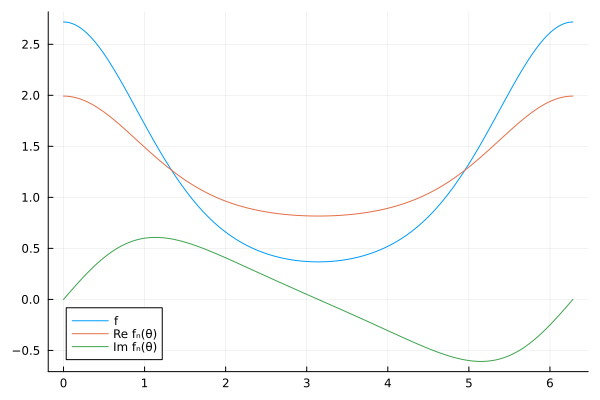

In [11]:
f = θ -> exp(cos(θ))
f̂ = [fouriercoefficient(f, k) for k = 0:n-1]
fₙ = θ -> transpose(T(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, f.(g); label="f")
plot!(g, real(fₙ.(g)); label="Re fₙ(θ)")
plot!(g, imag(fₙ.(g)); label="Im fₙ(θ)")
# Fails to converge

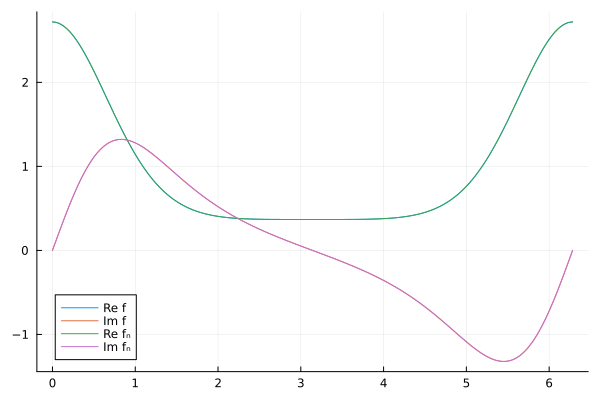

In [12]:
f = θ -> exp(exp(im*θ))
f̂ = [fouriercoefficient(f, k) for k = 0:n-1]
fₙ = θ -> transpose(T(θ))*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, real.(f.(g)); label="Re f")
plot!(g, imag.(f.(g)); label="Im f")
plot!(g, real(fₙ.(g)); label="Re fₙ")
plot!(g, imag(fₙ.(g)); label="Im fₙ")
# The real and imaginary parts match to high accuracy
# END

**Problem 1(c)** A cosine expansion is a special case of Fourier series of the form
$$
f(θ) = ∑_{k=0}^∞ f̌_k \cos k θ.
$$
Derive an expression for $f̌_k$ and plot the finite cosine expansion
$$
fₙ(θ) = ∑_{k=0}^{ n-1} f̌_k \cos k θ
$$
for $f(θ) = \exp(θ)$ and $f(θ) = \exp(\cos(θ))$. You may assume $f$ is real
and the returned coefficients should be real.
For which of these functions does the approximation appear to converge?

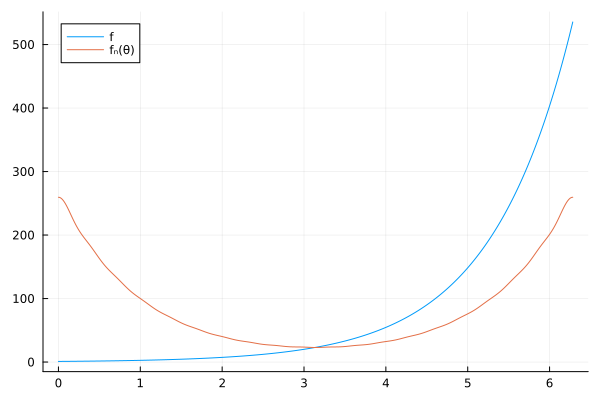

In [13]:
n = 20
function cosinecoefficient(f, k)
    # TODO: use quadgk to approximate f̌_k
    # SOLUTION
    # We can either recall the integral formula or use the following to relate to the Fourier coefficient.
    # We have
    # f̂ₖ \exp(ikθ) = f̂ₖ \cos(kθ) + i f̂ₖ \sin(kθ)
    # f̂₋ₖ \exp(-ikθ) = f̂₋ₖ \cos(kθ) - i f̂₋ₖ \sin(kθ)
    # thus ignoring the sin terms we get f̌_k = f̂ₖ + f̂₋ₖ.
    # apart from the `k = 0` case.
    # Note in the case where f is even this simplifies as f̂ₖ = f̂₋ₖ.
    # So your solution might be different if you used this property.
    if k ≠ 0
        real(fouriercoefficient(f, k) + fouriercoefficient(f, -k))
    else
        real(fouriercoefficient(f, 0))
    end
    # END
end
@test cosinecoefficient(θ -> exp(cos(θ)), 5) isa Float64
@test cosinecoefficient(θ -> exp(cos(θ)), 5) ≈ 0.0005429263119137845

# TODO: plot the truncated cosine expansion with coefficients ranging from 0:n-1
# SOLUTION
f̂ = [cosinecoefficient(exp, k) for k = 0:n-1]
C = θ -> [cos(k*θ) for k = 0:n-1] # Create the Cosine basis
fₙ = θ -> C(θ)'f̂ # finite Cosine expansion, we can use ' as C(θ) is real now.
g = range(0, 2π, 1000) # plotting grid
plot(g, exp.(g); label="f")
plot!(g, fₙ.(g); label="fₙ(θ)") ## The approximation fails

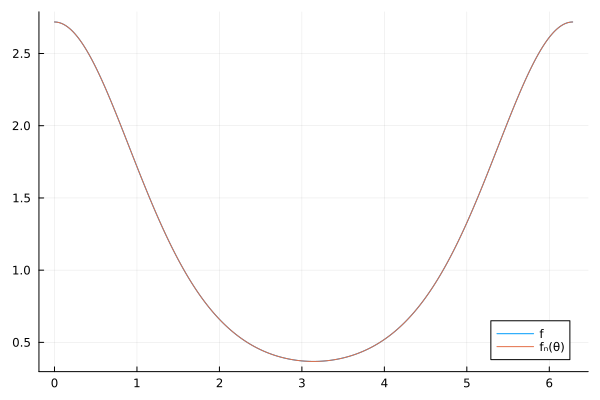

In [14]:
f = θ -> exp(cos(θ))
f̂ = [cosinecoefficient(f, k) for k = 0:n-1]
fₙ = θ -> C(θ)'*f̂ # finite Fourier series
g = range(0, 2π, 1000) # plotting grid
plot(g, f.(g); label="f")
plot!(g, fₙ.(g); label="fₙ(θ)")
# Matches to high accuracy
# END

### V.1.1 Convergence of Fourier series

Different function have different rates of convergence for their Fourier series,
which is largely dictated by the rate of decay in their coefficients. We can explore
how different _regularity_, i.e., the smoothness of the function, influences the rate of decay
of a Fourier expansion.

----

**Problem 2(a)** Plot  the absolute value of coefficients for the functions $θ$,
$θ (2π - θ)$ and $θ^2 (2π-θ)^2$ for $k = 1,…,100$. By scaling the $x$- and $y$-axis logarithmically deduce
experimentally the rate of decay.

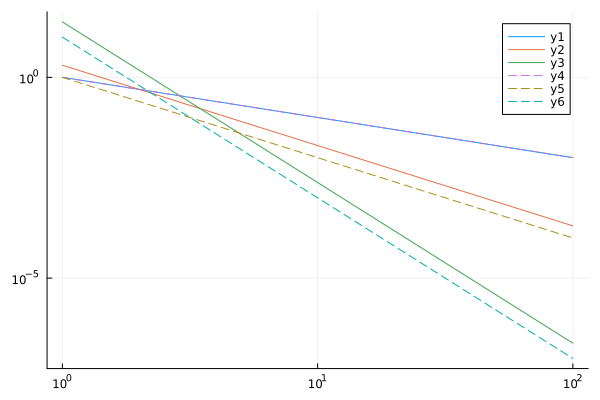

In [15]:
# TODO: plot the coefficients for the three functions with different smoothness properties and deduce the rate of decay.
# SOLUTION
plot(1:100, [abs.(fouriercoefficient(θ -> θ, k)) for k = 1:100]; yscale=:log10, xscale=:log10)
plot!(1:100, [abs.(fouriercoefficient(θ -> θ * (2π-θ), k)) for k = 1:100]; yscale=:log10, xscale=:log10)
plot!(1:100, [abs.(fouriercoefficient(θ -> θ^2 * (2π-θ)^2, k)) for k = 1:100]; yscale=:log10, xscale=:log10)

plot!(1:100, (1:100) .^ (-1); linestyle=:dash)
plot!(1:100, (1:100) .^ (-2); linestyle=:dash)
plot!(1:100, 10(1:100) .^ (-4); linestyle=:dash)

# It appears to be O(1/k),  O(1/k^2) and O(1/k^4)

# END

**Problem 2(b)** Repeat the above for $1/(\cos^2 θ + 1)$ and $1/(25 \cos^2 θ + 1)$, $\exp(\cos θ)$, now only scaling the $y$-axis logarithmically. Is the
convergence algebraic, exponential, or super-exponential?

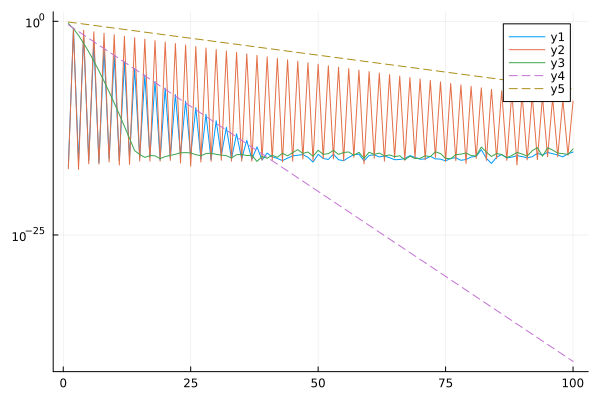

In [16]:
# TODO: plot the coefficients for the three functions with different smoothness properties and deduce the rate of decay.

# SOLUTION
plot(1:100, [abs.(fouriercoefficient(θ -> 1/(cos(θ)^2+1), k)) for k = 1:100]; yscale=:log10)
plot!(1:100, [abs.(fouriercoefficient(θ -> 1/(25cos(θ)^2+1), k)) for k = 1:100]; yscale=:log10)
plot!(1:100, [abs.(fouriercoefficient(θ -> exp(cos(θ)), k)) for k = 1:100]; yscale=:log10)

# First two examples are exponential:
plot!(1:100, 2.5 .^ (-(1:100)); linestyle=:dash) # first example is roughly O(2.5^(-k))
plot!(1:100, 1.2 .^ (-(1:100)); linestyle=:dash) # second example is roughly O(1.2^(-k))
# Third example is super-exponential
# END

----

### V.1.2 Trapezium rule and discrete Fourier coefficients

Above we use `quadgk` to compute the Fourier integrals, however, this has highly limited the number of coefficients
we can compute as it becomes prohibitively expensive for large `k`. Instead, we can leverage the Trapezium rule which has
highly structured error properties for computing Fourier integrals. We can use a modified version of the `trapeziumrule` function
from Lab 1:

In [17]:
function periodictrapeziumrule(f, n)
    ret = 0.0
    for j = 0:n-1
        ret = ret + f(2π*j/n)
    end
    ret/n
end

f = θ -> exp(cos(θ))
@test periodictrapeziumrule(f, 10) ≈ quadgk(f, 0, 2π)[1]/(2π)

Test Passed

This satisfies the discrete orthogonality property:

In [18]:
n = 5
k = 3
@test [periodictrapeziumrule(θ -> exp(im*(k-ℓ)*θ), n) for ℓ=-20:20] ≈ [mod(ℓ,n) == mod(k,n) ? 1 : 0 for ℓ=-20:20]

Test Passed

### V.1.3 Convergence of Approximate Fourier expansions

We can use the periodic trapezium rule to compute discrete Fourier coefficients $f̂_k^n$ via:

In [19]:
discretefouriercoefficient(f, k, n) = periodictrapeziumrule(θ -> exp(-im*k*θ)f(θ), n)

discretefouriercoefficient (generic function with 1 method)

These satisfy the aliasing formula
$$
f̂_k^n = ⋯ + f̂_{k-n} + f̂_k + f̂_{k+n} + …
$$
which we can verify for this case since $f̂_k$ decays very rapidly:

In [20]:
n = 4
@test discretefouriercoefficient(f, 1, n) ≈  fouriercoefficient(f, 1-2n) + fouriercoefficient(f, 1-n) + fouriercoefficient(f, 1) + fouriercoefficient(f, 1+n) + fouriercoefficient(f, 1+2n)

Test Passed

------

**Problem 3** Implement the following function `discretecosinecoefficient(f, k, n)` that implements the discrete Cosine coefficient defined via
$$
c_k^n :=  {1 \over n} ∑_{j=1}^n f(θ_j) \cos k θ_j \begin{cases} 1 & k = 0 \\ 2 & \hbox{otherwise} \end{cases}
$$
where $θ_j = π(j-1/2)/n$.

In [21]:
function discretecosinecoefficient(f, k, n)
    # TODO: implement the above approximation to the coefficient in the cosine expansion
    # SOLUTION
    ret = 0.0
    for j = 1:n
        θⱼ = π*(j-1/2)/n
        ret = ret + f(θⱼ)*cos(k*θⱼ)
    end
    if k == 0
        ret/n
    else
        2ret/n
    end
    # END
end

n = 5
@test [discretecosinecoefficient(θ -> 1, ℓ, n) for ℓ = 0:n-1] ≈ [ℓ == 0 ? 1 : 0 for ℓ=0:n-1]

k = 3
@test [discretecosinecoefficient(θ -> cos(k*θ), ℓ, n) for ℓ = 0:n-1] ≈ [ℓ == k ? 1 : 0 for ℓ=0:n-1]

Test Passed

------

## V.2 Discrete Fourier Transform

The discrete Fourier transform (DFT) expresses the map from function values to discrete Fourier coefficients as a matrix:

In [22]:
discretefouriertransform(n) = [exp(-2im*π/n * k*j) for k=0:n-1,j=0:n-1]/sqrt(n)

n = 10
Q = discretefouriertransform(n)
@test Q'Q ≈ I # Q is unitary
θ = [2π*j/n for j=0:n-1]
# Matches the discrete Fourier coefficient:
@test Q/sqrt(n) * exp.(θ) ≈ [discretefouriercoefficient(exp, k, n) for k=0:n-1]

Test Passed

FFTW.jl gives its own implementation of the DFT (up to multiplication by $\sqrt n$) computed via the Fast Fourier Transform (FFT):

In [23]:
@test fft(exp.(θ)) ≈ sqrt(n) * Q * exp.(θ)

Test Passed

Matrix multiplication is $O(n^2)$ operations whilst the FFT costs $O(n \log n)$ operations, which is
a substantial speedup.

-----
**Problem 4** Use `fft` in the function `specialsum(n)` to construct a vector to compute $[S_n(0),…,S_n(n-1)]$ for
$$
   S_n(k) := ∑_{p=0}^∞ {1 \over (k+p n)!}.
$$

In [24]:
function specialsum(n)
    # TODO: implement a numerical algorithm using fft to compute [S_n(0),…,S_n(n-1)], fast enough that the test passes
    # SOLUTION
    θ = range(0,2π,n+1)[1:end-1] # == [2π*j/n for j=0:n-1]
    fft(exp.(exp.(im .* θ)))/n
    # END
end


n = 5
@test specialsum(n) ≈ [sum(1/factorial(big(k+p*n)) for p = 0:10) for k=0:n-1]
n = 100_000
@test length(specialsum(n)) == n
@test specialsum(n)[1:10] ≈ [1/factorial(k) for k=0:9]

Test Passed

-----

### V.2.1 Trigonometric Interpolation

An important property of approximate Fourier expansions is that they interpolate the data at the specified grid.
In the case of the Fourier–Taylor expansion we can observe this by plotting the real (and imaginary) part of the expansion:

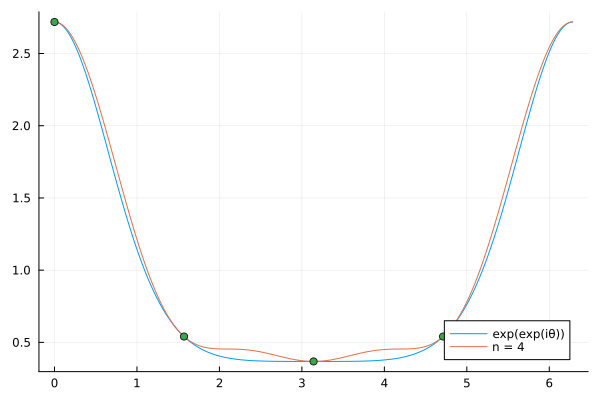

In [25]:
g = range(0,2π,1000) # plotting grid
f = θ -> exp(exp(im*θ)) # function with a converging Fourier–Taylor expansion
plot(g, real.(f.(g)); label="exp(exp(iθ))")
n = 4
θ = [2π/n*j for j=0:n-1]
𝐟ₖ = fft(f.(θ))/n
fₙ = θ -> transpose([exp(im*k*θ) for k=0:n-1])𝐟ₖ
plot!(g, real.(fₙ.(g)); label="n = $n")
scatter!(θ, real.(f.(θ)); label=nothing) # we interpolate exactly at the grid points

This example converges very rapidly (and with `n=6` the two curves would be indistinguishable).
But the interpolation property is true even for functions where we fail to converge:

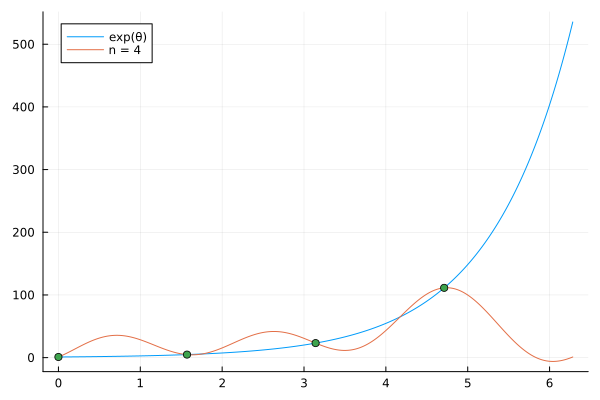

In [26]:
f = θ -> exp(θ) # function without a converging Fourier–Taylor expansion
plot(g, real.(f.(g)); label="exp(θ)")
n = 4
θ = [2π/n*j for j=0:n-1]
𝐟ₖ = fft(f.(θ))/n
fₙ = θ -> transpose([exp(im*k*θ) for k=0:n-1])𝐟ₖ
plot!(g, real.(fₙ.(g)); label="n = $n")
scatter!(θ, real.(f.(θ)); label=nothing) # we still interpolate exactly at the grid points

------

**Problem 5(a)** Plot the real part of the approximate Fourier expansion
$$
f_{-m:m}(θ) : = ∑_{k=-m}^m f̂_k^n {\rm e}^{{\rm i}kθ}
$$
and verify that it interpolates $f(θ) = \exp(θ)$ at the specified grid for $m=5,10,20$. Does the approximation appear to converge?

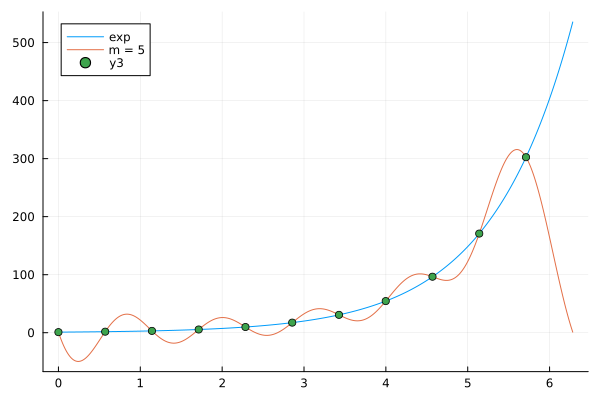

In [27]:
# TODO: Compare $\exp(θ)$ to its approximate Fourier expansion and describe the observed convergence
# SOLUTION

g = range(0,2π,1000)
plot(g, exp.(g); label="exp")
m = 5
𝐟ₖ = [discretefouriercoefficient(exp, k, 2m+1) for k =-m:m]
fₙ = θ -> transpose([exp(im*k*θ) for k=-m:m])𝐟ₖ
plot!(g, real.(fₙ.(g)); label="m = $m")
θ = [2π/(2m+1)*j for j=0:2m]
scatter!(θ, exp.(θ)) # we interpolate

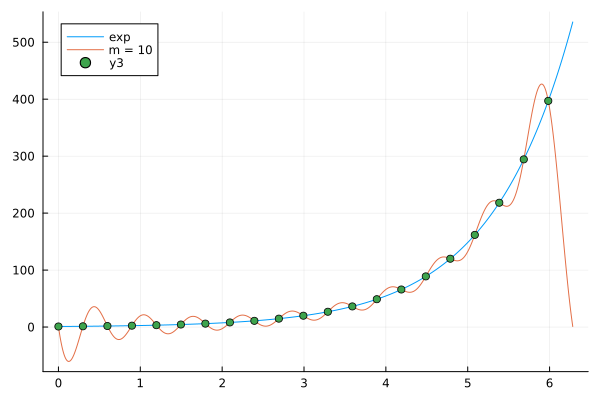

In [28]:
m = 10
plot(g, exp.(g); label="exp")
𝐟ₖ = [discretefouriercoefficient(exp, k, 2m+1) for k =-m:m]
fₙ = θ -> transpose([exp(im*k*θ) for k=-m:m])𝐟ₖ
plot!(g, real.(fₙ.(g)); label="m = $m")
θ = [2π/(2m+1)*j for j=0:2m]
scatter!(θ, exp.(θ)) # we interpolate

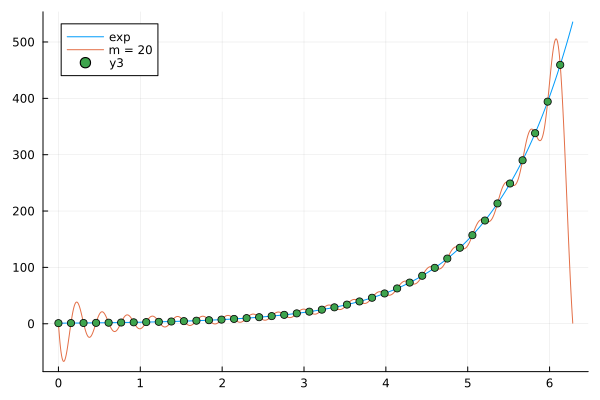

In [29]:
m = 20
plot(g, exp.(g); label="exp")
𝐟ₖ = [discretefouriercoefficient(exp, k, 2m+1) for k =-m:m]
fₙ = θ -> transpose([exp(im*k*θ) for k=-m:m])𝐟ₖ
plot!(g, real.(fₙ.(g)); label="m = $m")
θ = [2π/(2m+1)*j for j=0:2m]
scatter!(θ, exp.(θ)) # we interpolate

# it appears to converge away from 0 and 2π.


# END

**Problem 5(b)** Consider the approximate cosine expansion
$$
f_n(θ) = ∑_{k=0}^{n-1} c_k^n \cos k θ.
$$
Compare $f_n$ and $f$ for  $f(θ) = \exp θ$  and $\exp(\cos(θ))$ on $[0,π]$ for $n = 5, 20$.
Does the approximate cosine expansion interpolate both functions? Expain how the convergence properties better than Fourier, even for non-even functions.
Can you explain this phenomena?

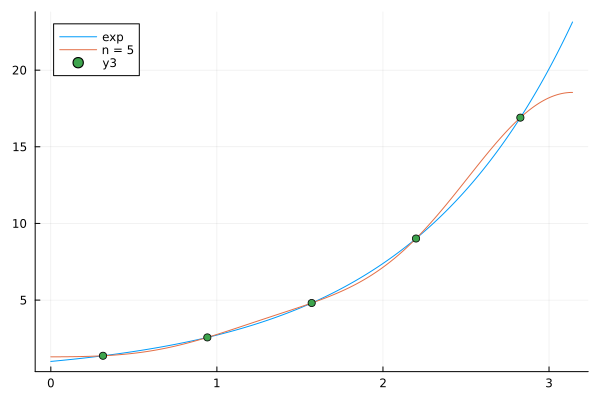

In [30]:
# TODO: by plotting the cosine expansion make some observations on the interpolation and convergence

# SOLUTION
g = range(0,π,1000)
plot(g, exp.(g); label="exp")
n = 5
𝐜ₖ = [discretecosinecoefficient(exp, k, n) for k =0:n-1]
fₙ = θ -> [cos(k*θ) for k=0:n-1]'𝐜ₖ
plot!(g, fₙ.(g); label="n = $n")
θ = [π*(j-1/2)/n for j=1:n]
scatter!(θ, exp.(θ)) # we interpolate

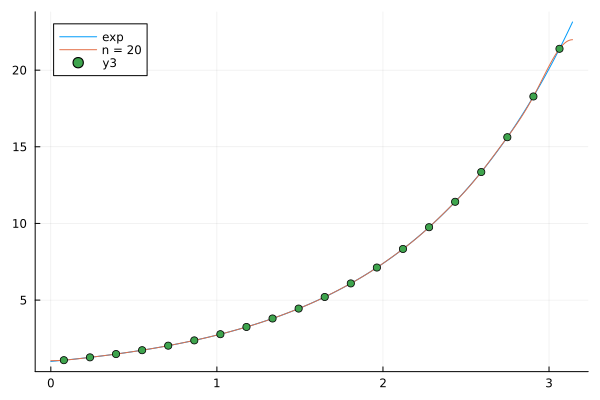

In [31]:
plot(g, exp.(g); label="exp")
n = 20
𝐜ₖ = [discretecosinecoefficient(exp, k, n) for k =0:n-1]
fₙ = θ -> [cos(k*θ) for k=0:n-1]'𝐜ₖ
plot!(g, fₙ.(g); label="n = $n")
θ = [π*(j-1/2)/n for j=1:n]
scatter!(θ, exp.(θ)) # we interpolate, but this time we converge!!

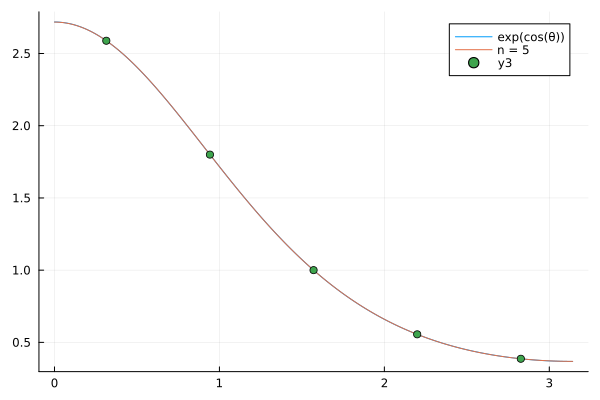

In [32]:
g = range(0,π,1000)
f = θ -> exp(cos(θ))
plot(g, f.(g); label="exp(cos(θ))")
n = 5
𝐜ₖ = [discretecosinecoefficient(f, k, n) for k =0:n-1]
fₙ = θ -> [cos(k*θ) for k=0:n-1]'𝐜ₖ
plot!(g, fₙ.(g); label="n = $n")
θ = [π*(j-1/2)/n for j=1:n]
scatter!(θ, f.(θ)) # we interpolate, but even with just 5 points it matches the function exactly to the eye

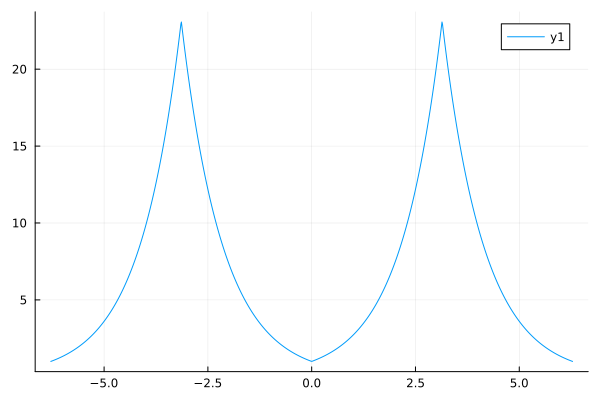

In [33]:
plot(g, f.(g); label="exp(cos(θ))")
n = 20
𝐜ₖ = [discretecosinecoefficient(f, k, n) for k =0:n-1]
fₙ = θ -> [cos(k*θ) for k=0:n-1]'𝐜ₖ
plot!(g, fₙ.(g); label="n = $n")
θ = [π*(j-1/2)/n for j=1:n]
scatter!(θ, f.(θ)) # still matches exactly

# The explanation is probably not immediately obvious but results since a cosine expansion approximates a "reflection" of
# the input function that makes it even, that is in the case of exp(θ) we are actually approximating


g = range(-2π,2π,1000)
f_even = θ -> if 0 ≤ θ ≤ π
    exp(θ)
elseif π ≤ θ ≤ 2π
    exp(2π-θ)
elseif -π ≤ θ ≤ π
    exp(-θ)
elseif -2π ≤ θ ≤ -π
    exp(2π+θ)
end

plot(g, f_even.(g))
# This extension matches $\exp(θ)$ exactly on $[0,π]$ but is periodic and continuous, hence has better convergence properties
# than our original Fourier example.

# END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*